# Deconvolution of Kripton data

Deconvolution of Kripton data

In [3]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [5]:
import FEE as FE

In [ ]:
from scipy import signal

In [6]:
import time

In [148]:
import pandas as pd

## Revised on:

In [141]:
print(time.strftime("%d/%m/%Y"))

05/11/2016


In [142]:
print(time.strftime("%H:%M:%S"))

17:54:07


In [160]:
def wait():
    """
    A simple convenience name for raw_input
    """
    raw_input("Press a key...")

###  Code exercized

In [9]:
!pep8 ../Sierpe/FEE.py

In [10]:
!pyflakes ../Sierpe/FEE.py

In [11]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### Deconvolution function

#### coeff_clean = freq_zerod

Nominal values:


C1=3100 nF

R1=1567 ohm

f_sample = (1/25 ns)

freq_zero = 1/(R1*C1);

freq_zerod = freq_zero / (f_sample*np.pi)

#### coef_blr=fee.freq_LHPFd*np.pi

freq_LHPFd = freq_LHPF/(f_sample*np.pi)

freq_LHPF = 1./(R * C)

In [93]:
def find_baseline(signal_i, mau_len=1000):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events

    """
    
    nm = mau_len
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = signal.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    return baseline, noise_rms

In [143]:
def deconvolve_signal(signal_daq, mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1=5, thr2=1,
                      filter_c=True):
    """
    Deconvolve the signal. 
    1) compute the baseline and the noise rms
    2) clean the signal
    3) apply BLR
    """
    coef = coef_blr
    nm = mau_len
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    wait_over = np.zeros(len_signal_daq, dtype=np.int8)
    
    
    BASELINE, noise_rms = find_baseline(signal_daq, mau_len=nm)
    MAU[0:nm] = BASELINE
    
    # change sign and subtract baseline
    signal_daq =  BASELINE - signal_daq
 
    # clean function
    if (filter==True):
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    w_over = 0 
    offset = 0
    
    for k in range(nm,len_signal_daq):
        trigger_line = MAU[k-1] + thr1*noise_rms
        pulse_on[k] = p_on
        wait_over[k] = w_over

        # condition: raw signal raises above trigger line and
        # we are not in the tail
        # (w_over == 0)
        if signal_daq[k] > trigger_line and w_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value
            # of the MAU before pulse starts (at k-1)

            if p_on == 0: # pulse just started
                offset = MAU[k-1]
                p_on = 1

            # Pulse is on: Freeze the MAU
            MAU[k] = MAU[k-1]

            #update recovered signal, correcting by offset
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset
            
        else:  # signal_daq[k] < trigger_line and w_over == 1

        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if p_on == 1: # reconstructed signal still on
                # switch the pulse off only when recovered signal
                # drops below threshold
                # slide the MAU, still frozen.
                # keep recovering signal

                MAU[k] = MAU[k-1]
                signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
                acum[k] = acum[k-1] + signal_daq[k] - offset
                
                # if the recovered signal drops before trigger line
                # rec pulse is over!
                
                if signal_r[k] < trigger_line:
                    w_over = 1  #start tail compensation
                    p_on = 0   #recovered pulse is over


            else:  # recovered signal has droped below trigger line
            # need to compensate the tail to avoid drifting due to erros in
            # baseline calculatoin

                if w_over == 1: # compensating pulse
                    # recovered signal and raw signal
                    # must be equal within a threshold
                    # otherwise keep compensating pluse

                    if abs(signal_daq[k-1] - signal_r[k-1]) > thr2*noise_rms:
                        # raw signal still not close to recovered signal
                        # keep compensating pulse
                        
                        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) +\
                                      coef*acum[k-1] 
                        acum[k] = acum[k-1] + signal_daq[k] - offset

                    else:  # raw signal ~=  recovered signal: we are done

                        w_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        MAU[k] = np.mean(signal_daq[k-nm:k])


                else: #signal still not found

                    # update MAU and signals
                    MAU[k] = np.mean(signal_daq[k-nm:k]*1.)
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
                    

    return  signal_r, acum, pulse_on, wait_over, MAU

#### List the files

In [114]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.root.h5
run_2644.gdc1next.004.next1el_2644.root.h5
run_2644.gdc1next.005.next1el_2644.root.h5
run_2644.gdc1next.006.next1el_2644.root.h5
run_2644.gdc1next.007.next1el_2644.root.h5
run_

#### Open and inspect files

In [86]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

In [87]:
kr2609

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 17

## Testing new deconvolution with Kripton data

In [88]:
pmtrwf = kr2609.root.RD.pmtrwf

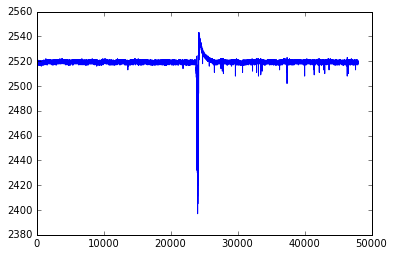

In [89]:
plt.plot(pmtrwf[0,0])

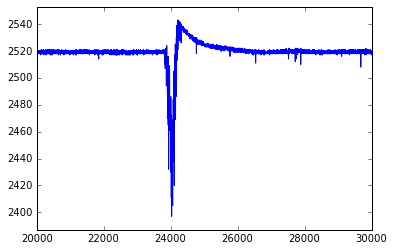

In [90]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

In [174]:
signal_r, acum, pulse_on, wait_over, MAU = deconvolve_signal(pmtrwf[0,0], mau_len=1000, 
                      coef_clean=dataPMT['coef_c'][0], coef_blr=dataPMT['coef_blr'][0], 
                      thr1 = 5, thr2=1, filter_c=True)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


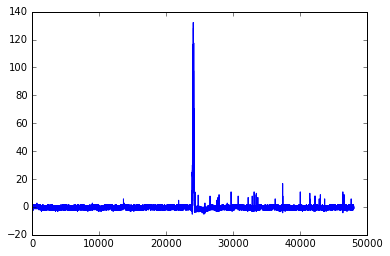

In [175]:
plt.plot(signal_r)

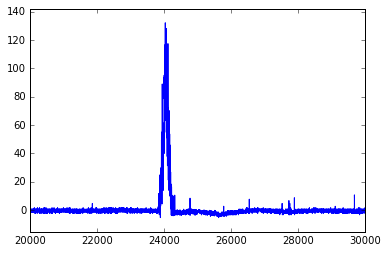

In [176]:
mpl.plts(signal_r, signal_start=20000, signal_end=30000, offset=10)

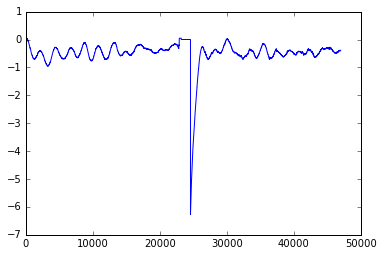

In [177]:
plt.plot(MAU[1000:])

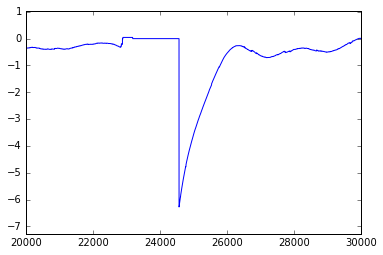

In [179]:
mpl.plts(MAU[1000:], signal_start=20000, signal_end=30000, offset=1)

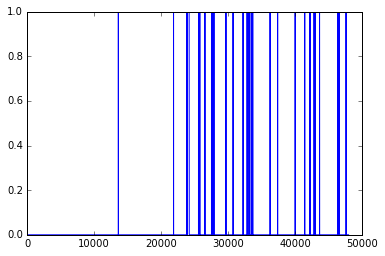

In [180]:
plt.plot(pulse_on)

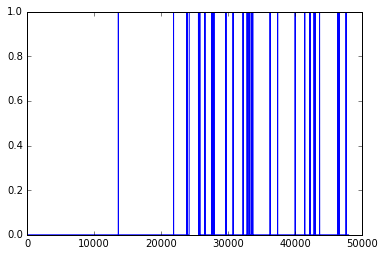

In [181]:
plt.plot(wait_over)

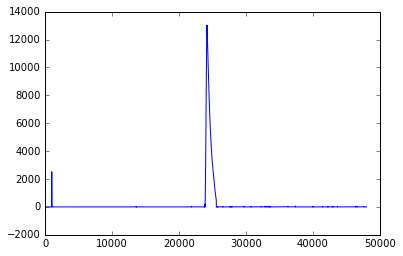

In [182]:
plt.plot(acum)

In [190]:
signal_r, acum, pulse_on, wait_over, MAU = deconvolve_signal(pmtrwf[0,11], mau_len=1000, 
                      coef_clean=dataPMT['coef_c'][11], coef_blr=dataPMT['coef_blr'][11], 
                      thr1 = 7, thr2=1, filter_c=True)

baseline = 2504.593 noise (LSB_rms) = 0.733409086996


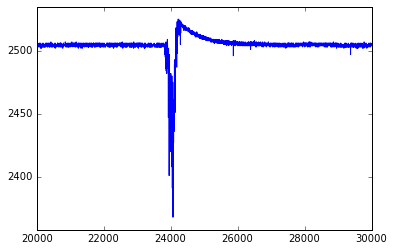

In [191]:
mpl.plts(pmtrwf[0,11], signal_start=20000, signal_end=30000, offset=10)

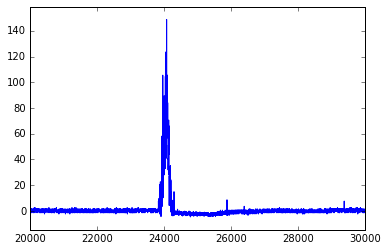

In [192]:
mpl.plts(signal_r, signal_start=20000, signal_end=30000, offset=10)

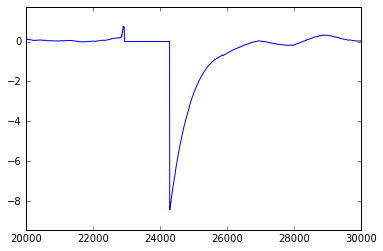

In [193]:
mpl.plts(MAU[1000:], signal_start=20000, signal_end=30000, offset=1)

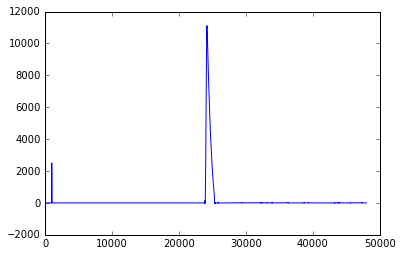

In [194]:
plt.plot(acum)

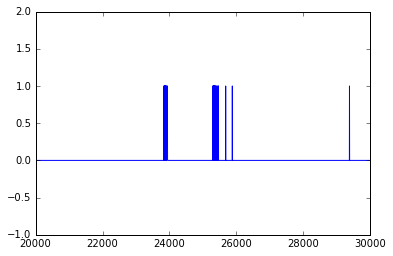

In [195]:
mpl.plts(pulse_on, signal_start=20000, signal_end=30000, offset=1)

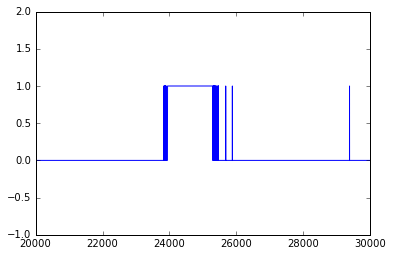

In [196]:
mpl.plts(wait_over, signal_start=20000, signal_end=30000, offset=1)

In [144]:
signal_r, acum, pulse_on, wait_over, MAU = deconvolve_signal(pmtrwf[0,0], mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1 = 5, thr2=1, filter_c=False)

baseline = 2518.755 noise (LSB_rms) = 0.790949177002


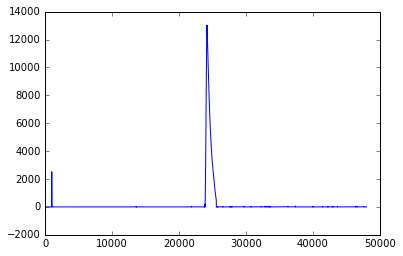

In [140]:
plt.plot(acum)

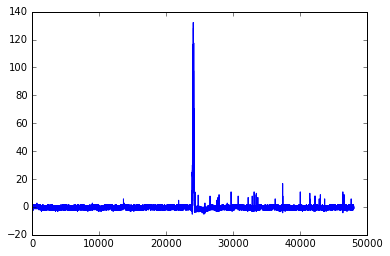

In [145]:
plt.plot(signal_r)

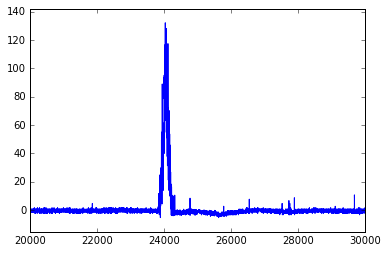

In [146]:
mpl.plts(signal_r, signal_start=20000, signal_end=30000, offset=10)

### Effect of cleaning not visible for short signals 

## Calibration data

In [153]:
dataPMT = {}
dataPMT[0] = ['1',0,0.7068,2.905447E-06,1.632411E-03]
dataPMT[1] = ['3',18,0.8744,2.905447E-06,1.632411E-03]
dataPMT[2] = ['2',1,0.7213,2.806061E-06,1.611104E-03]
dataPMT[3] = ['4',19,0.7624,2.756265E-06,1.599356E-03]
dataPMT[4] = ['C',27,0.7921,3.138766E-06,1.566958E-03]
dataPMT[5] = ['B',26,0.866,3.965176E-06,1.649618E-03]
dataPMT[6] = ['A',9,0.7062,2.711644E-06,1.592963E-03]
dataPMT[7] = ['9',8,0.7278,3.127641E-06,1.612068E-03]
dataPMT[8] = ['8',23,0.7303,3.064543E-06,1.600683E-03]
dataPMT[9] = ['7',22,0.716,3.040463E-06,1.592718E-03]
dataPMT[10] = ['6',5,0.7323,3.113604E-06,1.575192E-03]
dataPMT[11] = ['5',4,0.7206,3.185979E-06,1.596322E-03]

In [156]:
pmtID = ['1','3','2','4','C','B','A','9','8','7','6','5']
elecID = [0,18,1,19,27,26,9,8,23,22,5,4]
noise_rms = [0.706,0.8744,0.7213,0.7624,0.7921,0.866,0.7062,0.7278,0.7303,0.716,0.7323,0.7206]
coef_c = [2.905447E-06,2.905447E-06,2.806061E-06,2.756265E-06,3.138766E-06,3.965176E-06,
          2.711644E-06,3.127641E-06,3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.632411E-03,1.611104E-03,1.599356E-03,1.566958E-03,1.649618E-03,
            1.592963E-03,1.612068E-03,1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]

In [158]:
dataPMT = pd.DataFrame({'pmtID': pmtID,'elecID': elecID,'noise_rms': noise_rms,
              'coef_c': coef_c,'coef_blr': coef_blr})

In [159]:
dataPMT

,coef_blr,coef_c,elecID,noise_rms,pmtID
0,0.001632,0.000003,0,0.7060,1
1,0.001632,0.000003,18,0.8744,3
2,0.001611,0.000003,1,0.7213,2
3,0.001599,0.000003,19,0.7624,4
4,0.001567,0.000003,27,0.7921,C
5,0.001650,0.000004,26,0.8660,B
6,0.001593,0.000003,9,0.7062,A
7,0.001612,0.000003,8,0.7278,9
8,0.001601,0.000003,23,0.7303,8
9,0.001593,0.000003,22,0.7160,7


In [204]:
def deconv_pmt(pmtrwf,dataPMT, thr1 = 5, thr2=1, event=0):
    """
    Deconvolution of a full event
    """
    NPMT = pmtrwf.shape[1]
    
    for i in range(NPMT):
        cc = dataPMT['coef_c'][i]
        cblr = dataPMT['coef_blr'][i]
        print('thr1 = {}, thr2 = {}'.format(thr1,thr2))
        print('deconvoluting PMT = {} with coef_clean = {} coef_blr = {}'.format(i,cc,cblr))
                                                                                
        signal_r, acum, pulse_on, wait_over, MAU = deconvolve_signal(pmtrwf[event,i], 
                                                                     mau_len=1000, 
                                                                     coef_clean=cc,
                                                                     coef_blr=cblr, 
                                                                     thr1 = thr1, thr2=thr2, 
                                                                     filter_c=True)
        
        #mpl.plts(pmtrwf[event,i], signal_start=20000, signal_end=30000, offset=10)
        #plt.show()
        #wait()
        
        mpl.plts(signal_r, signal_start=20000, signal_end=30000, offset=10)
        plt.show()
        wait()
    

thr1 = 10, thr2 = 1
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2518.755 noise (LSB_rms) = 0.790949177002


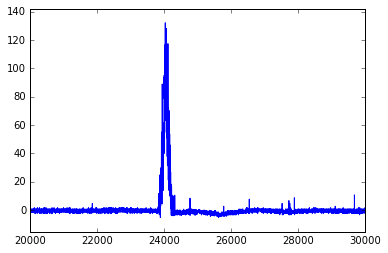

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 1 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2519.976 noise (LSB_rms) = 0.761579939339


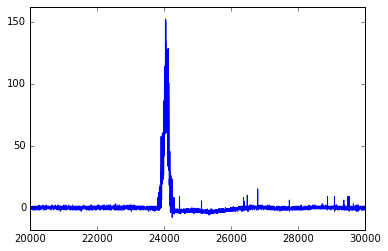

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 2 with coef_clean = 2.806061e-06 coef_blr = 0.001611104
baseline = 2458.523 noise (LSB_rms) = 0.764234947549


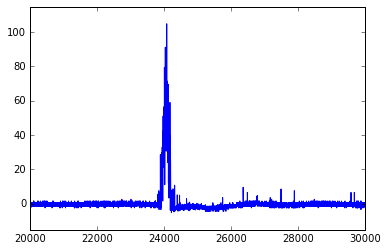

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.233 noise (LSB_rms) = 0.738414691252


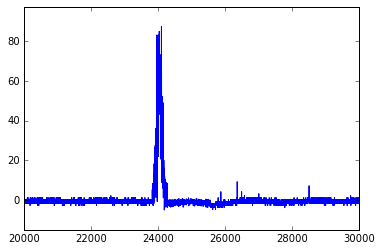

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.805 noise (LSB_rms) = 0.783318957123


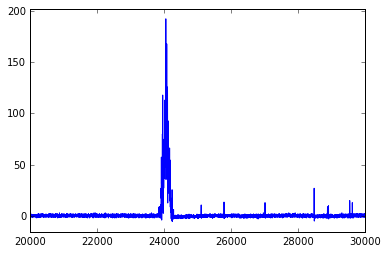

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.388 noise (LSB_rms) = 0.737563556583


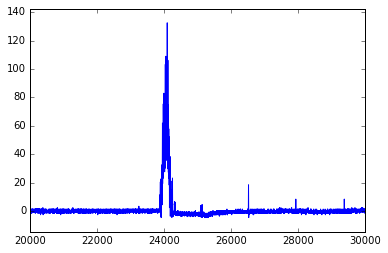

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 6 with coef_clean = 2.711644e-06 coef_blr = 0.001592963
baseline = 2502.72 noise (LSB_rms) = 0.777305734061


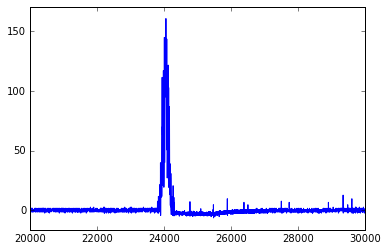

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.591 noise (LSB_rms) = 0.811404570715


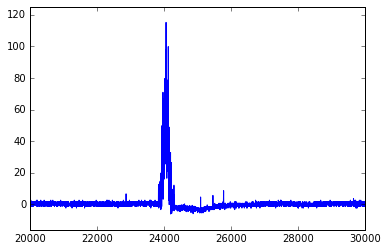

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.293 noise (LSB_rms) = 0.780871795342


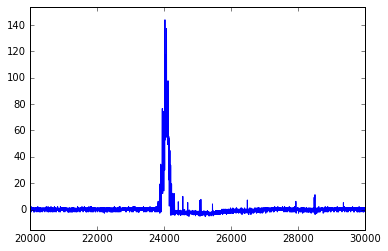

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.932 noise (LSB_rms) = 0.752291128448


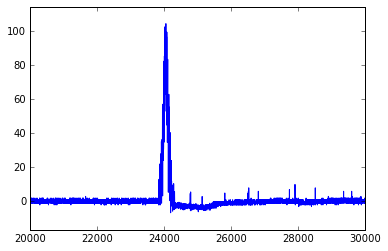

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.212 noise (LSB_rms) = 0.741353900378


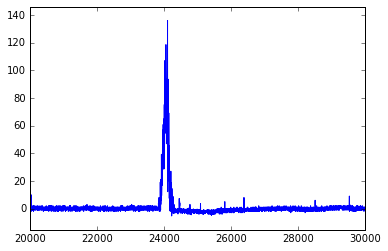

Press a key...
thr1 = 10, thr2 = 1
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.593 noise (LSB_rms) = 0.733409086996


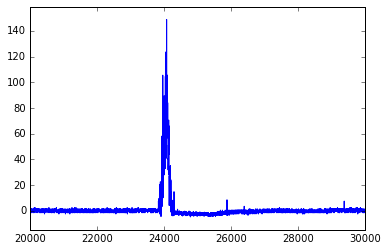

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 10, thr2=1, event=0)
